In [1]:
import requests
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import json
import torch

In [2]:
# Load API key from JSON file
with open('fda_key.json', 'r') as file:
    config = json.load(file)
api_key = config['api_key']


In [3]:
drugs = [
    "aspirin", "ibuprofen", "acetaminophen", "naproxen", 
    "amoxicillin", "ciprofloxacin", "azithromycin", "metronidazole",
    "atorvastatin", "simvastatin", "lovastatin", "rosuvastatin",
    "metformin", "glipizide", "glyburide", "insulin",
    "lisinopril", "losartan", "amlodipine", "diltiazem",
    "albuterol", "fluticasone", "budesonide", "montelukast",
    "sertraline", "citalopram", "fluoxetine", "paroxetine",
    "omeprazole", "lansoprazole", "ranitidine", "famotidine",
    "hydrochlorothiazide", "furosemide", "spironolactone", "triamterene",
    "prednisone", "methylprednisolone", "dexamethasone", "hydrocortisone",
    "diphenhydramine", "loratadine", "cetirizine", "fexofenadine",
    "morphine", "oxycodone", "hydrocodone", "fentanyl",
    "warfarin", "heparin", "enoxaparin", "apixaban",
    "levothyroxine", "thyroxine", "liothyronine", "methimazole",
    "digoxin", "amiodarone", "sotalol", "bisoprolol"
]  

In [4]:
def fetch_adverse_events(drug_name, limit=100):
    base_url = "https://api.fda.gov/drug/event.json"
    query = f"?api_key={api_key}&search=patient.drug.openfda.brand_name:\"{drug_name}\"&limit={limit}"
    url = base_url + query
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()['results']
    else:
        return None

In [5]:
all_events = []
for drug in drugs:
    events = fetch_adverse_events(drug)
    if events:
        for event in events:
            # Extracting relevant information
            age = event.get('patient', {}).get('patientonsetage', None)
            gender = event.get('patient', {}).get('patientsex', None)
            reactions = [r.get('reactionmeddrapt') for r in event.get('patient', {}).get('reaction', [])]
            all_events.append({'drug_name': drug, 'age': age, 'gender': gender, 'reactions': reactions})

# Convert to DataFrame
df = pd.DataFrame(all_events)

In [46]:
print(df.columns)

Index(['drug_name', 'age', 'gender', 'reactions'], dtype='object')


In [15]:
print(df.head(10))

  drug_name   age gender                                          reactions
0   aspirin  None      2                            [Drug hypersensitivity]
1   aspirin    66      2                                        [Back pain]
2   aspirin    71      1        [Adenoviral haemorrhagic cystitis, Pyrexia]
3   aspirin  None      2  [Cerebrovascular accident, Blood pressure incr...
4   aspirin    84      2               [Oedema peripheral, Fluid retention]
5   aspirin    58      1  [Hypertension, Dehydration, Night sweats, Pani...
6   aspirin  None      1                                      [Transfusion]
7   aspirin    77      1                             [Influenza, Pneumonia]
8   aspirin  None      2                                   [Rash, Dyspnoea]
9   aspirin    65      0                              [Disease progression]


In [20]:
#df.to_csv("drugevent.csv")
#df.to_json("drugevent.json")

In [12]:
print(torch.__version__)

2.1.1


In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# Assuming df is your DataFrame

# Enhanced Text Preprocessing
df['combined_reactions'] = df['reactions'].apply(lambda x: ' '.join(x))
# Add other preprocessing steps here (e.g., remove stop words, lemmatization)

# Improved Sentiment Analysis using BERT
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
sentence_embeddings = model.encode(df['combined_reactions'].tolist(), batch_size=64)  # Batch processing

# Elbow Method to determine the optimal number of clusters
wcss = []
for i in range(1, 11):  # Testing for k values from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(sentence_embeddings)
    wcss.append(kmeans.inertia_)



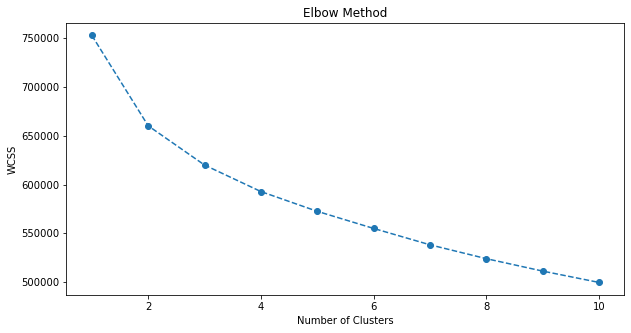

In [8]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

c:\Users\aquil\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\aquil\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


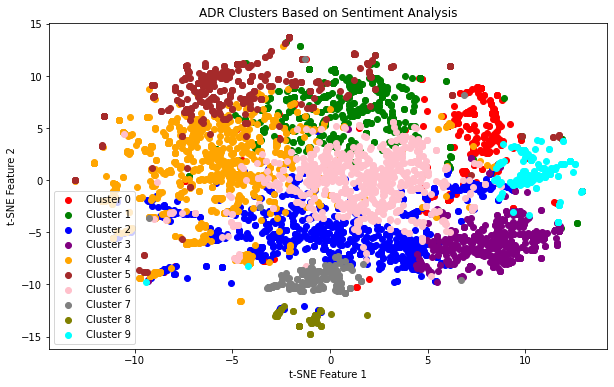

In [10]:
num_clusters = 10  # This is an example. Replace with the number from the elbow plot.
final_kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
final_kmeans.fit(sentence_embeddings)
df['cluster'] = final_kmeans.labels_

# Visualization using t-SNE
tsne = TSNE(n_components=2, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(sentence_embeddings)

plt.figure(figsize=(10,6))
colors = [
    'red', 'green', 'blue', 'purple', 'orange', 
    'brown', 'pink', 'gray', 'olive', 'cyan'
]

for i in range(num_clusters):
    plt.scatter(tsne_results[df['cluster'] == i, 0], tsne_results[df['cluster'] == i, 1], color=colors[i], label=f'Cluster {i}')
plt.title('ADR Clusters Based on Sentiment Analysis')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()


## Statistical Analysis

In [53]:
from sklearn.cluster import KMeans
import pandas as pd


# Assuming 'sentence_embeddings' is a list of lists or a 2D array
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(sentence_embeddings)

# Accessing the centroids
centroids = kmeans.cluster_centers_
print(centroids)

[[-0.66504276 -0.55408496  0.13075969 ... -0.62779707  0.26291466
  -0.04214542]
 [-0.42561135 -0.44451565  0.461185   ... -0.5437442   0.24464247
   0.08556678]
 [-0.33694068 -0.5569449   0.6121646  ... -0.5025403   0.05450232
   0.31311885]
 ...
 [-0.42308706 -0.7177389   0.94017506 ... -0.38950366 -0.272288
  -0.5366487 ]
 [-0.2598132  -1.2511791   0.8543798  ... -0.13966635 -0.23768073
  -0.17337085]
 [-0.6378744  -0.42826504 -0.2354899  ... -0.43382373  0.36823934
  -0.2630539 ]]


In [54]:
# Example: Examining the 10th data point in the DataFrame
data_point = df.iloc[0:11]  # DataFrames are zero-indexed
print(data_point)


   drug_name   age gender                                          reactions  \
0    aspirin   NaN      2                            [Drug hypersensitivity]   
1    aspirin  66.0      2                                        [Back pain]   
2    aspirin  71.0      1        [Adenoviral haemorrhagic cystitis, Pyrexia]   
3    aspirin   NaN      2  [Cerebrovascular accident, Blood pressure incr...   
4    aspirin  84.0      2               [Oedema peripheral, Fluid retention]   
5    aspirin  58.0      1  [Hypertension, Dehydration, Night sweats, Pani...   
6    aspirin   NaN      1                                      [Transfusion]   
7    aspirin  77.0      1                             [Influenza, Pneumonia]   
8    aspirin   NaN      2                                   [Rash, Dyspnoea]   
9    aspirin  65.0      0                              [Disease progression]   
10   aspirin  53.0      0                              [Disease progression]   

                                   comb

In [17]:
# Grouping by cluster
grouped_df = df.groupby('cluster')
print(grouped_df)
# Calculating descriptive statistics for each cluster
stats = grouped_df['age'].describe()  # Example for age. You can add more variables.
print(stats)
# Counting occurrences of gender in each cluster
gender_counts = grouped_df['gender'].value_counts()
print(gender_counts)



        count unique top freq
cluster                      
0         288     71  72   13
1         497     74  66   18
2         800     92  65   25
3         404     75  76   20
4        1025     95  77   40
5         503     80  71   22
6         774     88  66   51
7         200     58  72   12
8         131     39  56   11
9         192     71  63    8
cluster  gender
0        2         214
         1         138
         0          24
1        2         373
         1         245
         0          17
2        2         550
         1         380
         0          24
3        2         265
         1         206
         0          15
4        2         609
         1         552
         0          59
5        2         314
         1         244
         0          61
6        2         617
         1         279
         0          12
7        2         132
         1          89
         0          10
8        2         125
         1          16
         0           1
9  

In [23]:
from textblob import TextBlob

# Function to calculate sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Applying the function to the reactions column
df['sentiment_score'] = df['combined_reactions'].apply(get_sentiment)

# Now you can calculate the average sentiment score for each cluster
grouped_df = df.groupby('cluster')
average_sentiment = grouped_df['sentiment_score'].mean()
print(average_sentiment)


cluster
0   -0.031513
1   -0.010340
2   -0.048769
3   -0.332039
4    0.011517
5    0.003259
6   -0.032309
7   -0.002428
8   -0.000219
9   -0.022333
Name: sentiment_score, dtype: float64


In [37]:
drug_counts = grouped_df['drug_name'].value_counts()
drug_counts.to_csv("count_of_drugs.csv")

In [38]:
import pandas as pd

# Assuming df is your DataFrame and it has 'cluster' and 'drug_name' columns

def get_most_least_frequent_drugs(sub_df):
    drug_counts = sub_df['drug_name'].value_counts()
    most_frequent = drug_counts.idxmax()  # Drug with the highest count
    least_frequent = drug_counts.idxmin()  # Drug with the lowest count
    return pd.Series({'Most Frequent Drug': most_frequent, 'Least Frequent Drug': least_frequent})

# Applying the function to each cluster
cluster_drug_info = df.groupby('cluster').apply(get_most_least_frequent_drugs)

# Optionally, save this information to a CSV
cluster_drug_info.to_csv("cluster_drug_info.csv")


In [39]:
print(cluster_drug_info)

        Most Frequent Drug Least Frequent Drug
cluster                                       
0                 morphine      spironolactone
1                 naproxen             heparin
2              hydrocodone           thyroxine
3            levothyroxine        lansoprazole
4                  heparin        atorvastatin
5            acetaminophen            apixaban
6               citalopram           thyroxine
7            levothyroxine          fluoxetine
8             atorvastatin        liothyronine
9             fexofenadine        lansoprazole


In [19]:
sample_descriptions = grouped_df['reactions'].apply(lambda x: x.sample(n=5))  # Get 5 random samples from each cluster
print(sample_descriptions)

cluster      
0        5137        [Blood creatinine abnormal, Drug interaction]
         4546                              [Road traffic accident]
         2217    [Compartment syndrome, Drug interaction, Post ...
         3851            [Rectal adenocarcinoma, Drug interaction]
         4447                              [Drug hypersensitivity]
1        5373                               [Abnormal weight gain]
         5557                                           [Headache]
         2120                     [Condition aggravated, Erythema]
         1948                                      [Rash pruritic]
         2231                     [Feeling abnormal, Hypertension]
2        331     [Back pain, Drug dose omission, Uterine haemor...
         4476    [Dyspnoea, Pain, Nausea, Diarrhoea, Spinal pai...
         2651    [Cerebral vasoconstriction, Hypertension, Drug...
         4998    [Dehydration, Prescribed overdose, Blood album...
         4896    [Sudden cardiac death, Aspergil

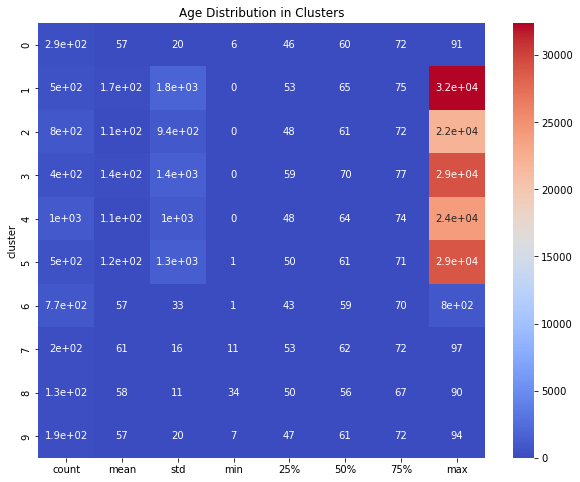

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Converting age to numeric
df['age'] = pd.to_numeric(df['age'], errors='coerce')  # 'coerce' will set invalid parsing as NaN

# Group by cluster and describe age
grouped_df = df.groupby('cluster')
age_stats = grouped_df['age'].describe()

# Creating a heatmap for age statistics
plt.figure(figsize=(10, 8))
sns.heatmap(age_stats, annot=True, cmap='coolwarm')
plt.title('Age Distribution in Clusters')
plt.show()


In [47]:
# Assuming df is your DataFrame and 'reactions' column contains lists of reactions

# Explode the 'reactions' column
df_exploded = df.explode('reactions')

# Find unique reactions
unique_reactions = df_exploded['reactions']

# Display the unique reactions
print(unique_reactions)



0                  Drug hypersensitivity
1                              Back pain
2       Adenoviral haemorrhagic cystitis
2                                Pyrexia
3               Cerebrovascular accident
                      ...               
5910             Urinary tract infection
5911                 Renal failure acute
5911                    Drug interaction
5912          Cardiac failure congestive
5912        Left ventricular hypertrophy
Name: reactions, Length: 24989, dtype: object


# Other obsolete code

In [48]:
unique_reactions.to_csv("adverse_drug_reaction.csv", index=False)


In [59]:
udf = pd.read_csv("adverse_drug_reaction.csv")

# Find unique reactions
unique_reaction = udf['reactions'].unique()

print(unique_reaction)


['Drug hypersensitivity' 'Back pain' 'Adenoviral haemorrhagic cystitis'
 ... 'Drug effect increased' 'Penile pain' 'Sarcoma']


In [63]:
unique_reaction = pd.DataFrame(unique_reaction)
unique_reaction.to_csv("adverse_drug_reactions.csv", index=False)

In [ ]:
reactions_df = pd.read_csv('adverse_drug_reactions.csv')
